In [1]:
import tensorflow
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

In [2]:
def image_display(image,title=''):
    plt.title(title)
    plt.imshow(image, cmap='Greys_r')
    plt.show()
    
def side2side_plotter(images):
    # Plot the result
    number_of_plots = len(images)
    if number_of_plots>1:
        fig , (ax)= plt.subplots(1, number_of_plots, figsize=(10, 9))
        fig.tight_layout()
        for i in range(number_of_plots):
            ax[i].imshow(images[i][0],cmap='Greys_r')
            ax[i].set_title(images[i][1])
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    elif number_of_plots==1:
        fig, ax= plt.subplots(1, 1, figsize=(5, 5)) 
        ax.imshow(images[0][0],cmap='Greys_r')
        ax.set_title(images[0][1])
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [4]:
# 1- calibrating camera

camera_images = glob.glob('camera_cal/*') 
print('Images available for calibrating camera: {}'.format(len(camera_images)))

#calibration rows/cols
nx = 9
ny = 6

#creating images_points and object_points list for calibrating camera
image_points = []
object_points = []

default_obj_point = np.zeros((ny*nx,3), np.float32)
default_obj_point[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

print('Wroking ...')
failed_corners = []
success_corners = []
for i , img in enumerate(camera_images):
    #read image
    im = mpimage.imread(img)
    #gray scale
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    #get corners
    ret, corners =  cv2.findChessboardCorners(gray_im, (nx,ny))
    if ret is True:
        image_points.append(corners)
        object_points.append(default_obj_point)
        cv2.drawChessboardCorners(im, (nx,ny), corners, ret)
        success_corners.append((im,img))
    else:
        failed_corners.append((i,img))
print('Finished collecting points')

Images available for calibrating camera: 20
Wroking ...
Finished collecting points


Detected corners:


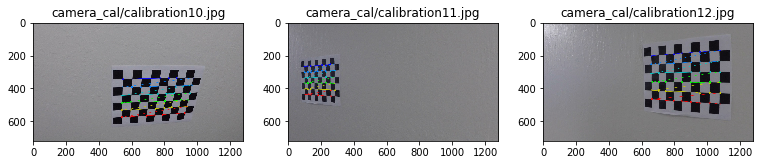

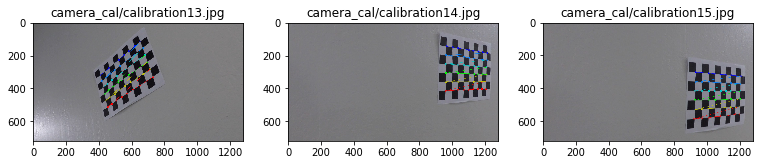

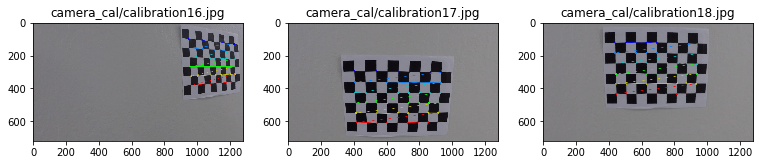

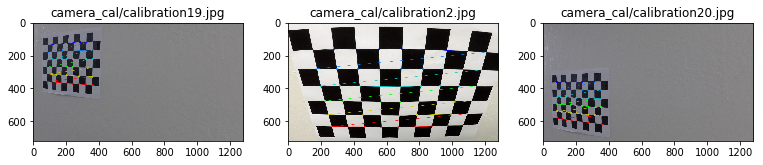

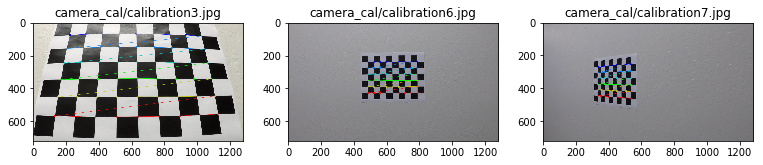

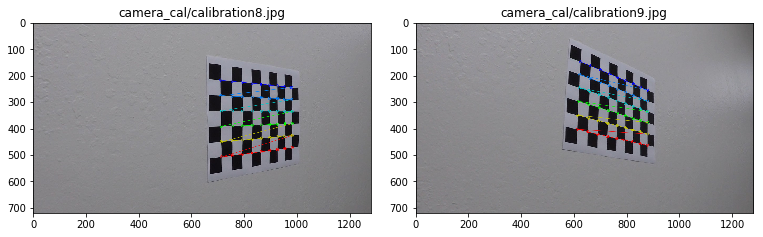

Failed on finding corners for the following images:
image #0, path: camera_cal/calibration1.jpg
image #14, path: camera_cal/calibration4.jpg
image #15, path: camera_cal/calibration5.jpg


In [5]:
print('Detected corners:')

for i in range(0,len(success_corners),3):
    display_images=[]
    im1= success_corners[i][0]
    display_images.append([im1,"{}".format(success_corners[i][1])])
    if (i+1) < len(success_corners):
        im2= success_corners[i+1][0]
        display_images.append([im2,"{}".format(success_corners[i+1][1])])
        if (i+2) < len(success_corners):
            im3= success_corners[i+2][0]
            display_images.append([im3,"{}".format(success_corners[i+2][1])])
    side2side_plotter(display_images)
    
print('Failed on finding corners for the following images:')
for i,im in failed_corners:
    print('image #{}, path: {}'.format(i,im))

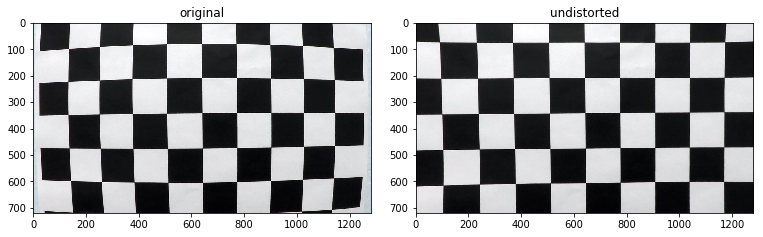

In [6]:
# step 2
def undistort(img):
    img_copy = np.copy(img)
    img_size=(img.shape[1],img_copy.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( object_points, image_points, img_size,None,None)
    undistort_image = cv2.undistort(img_copy, mtx, dist, None, mtx)
    return undistort_image

# testing calibrate and undistort on an image that was not used in 
img = cv2.imread('camera_cal/calibration1.jpg')
undistort_image = undistort(img)
u_images = [[img,'original'], [undistort_image,'undistorted']]
side2side_plotter(u_images)

In [8]:
# converting image to HLS channel
def gradient_binary(img, thresh=[90,200],orientation='x', ksize=3):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orientation=='y':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F,0,1, ksize=ksize)
    else:
        sobel = cv2.Sobel(gray_img, cv2.CV_64F,1,0, ksize=ksize)
    sobel_abs = np.absolute(sobel)
    sobel_scaled= np.uint8(255* sobel_abs/np.max(sobel_abs))
    sobel_binary = np.zeros_like(sobel_scaled)
    sobel_binary[(sobel_scaled>thresh[0])&(sobel_scaled<=thresh[1])]=1
    return sobel_binary

In [9]:
def hls_binary(img, thresh=[90,200], channel='s'):
    hls_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
    if channel =='h':
        hls_img = hls_img[:,:,0]
    elif channel == 'l':
        hls_img = hls_img[:,:,1]
    else:
        hls_img = hls_img[:,:,2]
    hls_binary= np.zeros_like(hls_img)
    hls_binary[(hls_img>thresh[0])&(hls_img<=thresh[1])]=1
    return hls_binary

In [10]:
#step 3
def combine_binaries(binary_img1, binary_img2, return_color_combination=False):
    color_combination=[]
    if return_color_combination:
        color_combination = np.dstack((np.zeros_like(binary_img1), binary_img1, binary_img2))
    binary = np.zeros_like(binary_img1)
    binary[(binary_img1==1)|(binary_img2==1)]=1
    return binary, color_combination

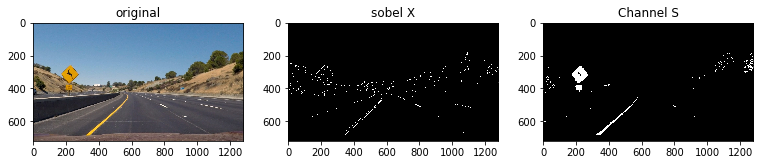

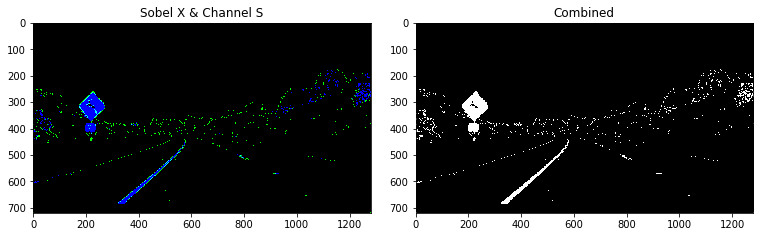

In [11]:

#testing sobel & hls
test_img = mpimage.imread('test_images/test2.jpg')
sobel_img = gradient_binary(test_img, thresh=[50,100])
hls_img = hls_binary(test_img, thresh=[150,255])
side2side_plotter([[test_img,'original'],[sobel_img,'sobel X'],[hls_img,'Channel S']])

combined_binary, color_combination = combine_binaries(sobel_img, hls_img, True)
side2side_plotter([[color_combination,'Sobel X & Channel S'],[combined_binary,'Combined']])


In [12]:
#step 4
def get_perspective_transformation(img, src_vertices, dst_vertices):
    src =np.float32(src_vertices)
    dst=np.float32(dst_vertices)
    M = cv2.getPerspectiveTransform(src,dst)
    warped_image = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    return warped_image

In [13]:
# region of interest
def display_region(original_img , gray_img, src_vertices):
    img_copy = np.copy(original_img)
    pts = np.array(src_vertices, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=3)
    return img_copy


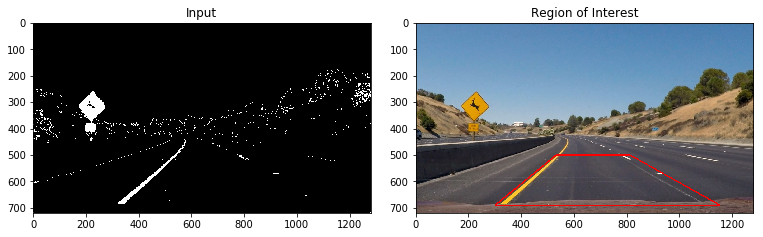

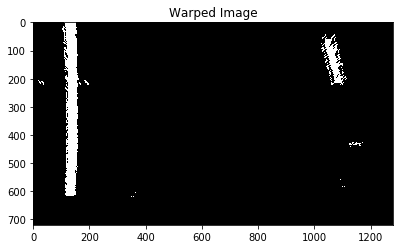

In [14]:
# test region & warp
test_img = mpimage.imread('test_images/test2.jpg')
img_size = [combined_binary.shape[0],combined_binary.shape[1]]
src_vertices =[[530,500],[810,500],[1150,690],[300,690]]

offset = 100
dst_vertices = [[offset,offset],[img_size[1]-offset,offset],[img_size[1]-offset,img_size[0]-offset],[offset,img_size[0]-offset]]
    
img_region = display_region(test_img,combined_binary,src_vertices)
warped_img = get_perspective_transformation(combined_binary,src_vertices,dst_vertices)
side2side_plotter([[combined_binary,'Input'],[img_region,'Region of Interest']])
side2side_plotter([[warped_img,'Warped Image']])


In [248]:
# step 5
# histogram | convolve
def sliding_window_histogram(img, n_windows=9):
    good_left = []
    good_right = []
    img_output = np.dstack((img, img, img))*255
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    plt.plot(histogram)
    plt.show()
    window_height = int(img.shape[0]/n_windows)
    #find halves
    midpoint= int(histogram.shape[0]/2)
    left_half = histogram[0:midpoint]
    right_half = histogram[midpoint:]
    
    #find nonzeros
    nonzero = img.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    #get the base
    left_base = np.argmax(left_half, axis=0)
    right_base = np.argmax(right_half, axis=0)+midpoint
    
    left_current = left_base
    right_current = right_base
    
    max_pix = 50
    margin =102
    for i in range(n_windows):
        y_high = img.shape[0] - i*window_height
        y_low = img.shape[0] - (i+1)*window_height
        
        x_left_low = left_current-margin
        x_left_high = left_current+margin
        
        x_right_low = right_current-margin
        x_right_high = right_current+margin
        
        cv2.rectangle(img_output, (x_left_low, y_low) ,(x_left_high, y_high), (0,255,0),2)
        cv2.rectangle(img_output, (x_right_low, y_low) ,(x_right_high, y_high), (0,255,0),2)
        
        good_left_indexes = ((nonzero_x>x_left_low)&(nonzero_x<x_left_high)&(nonzero_y>y_low)&(nonzero_y<y_high)).nonzero()[0]
        good_right_indexes = ((nonzero_x>x_right_low)&(nonzero_x<x_right_high)&(nonzero_y>y_low)&(nonzero_y<y_high)).nonzero()[0]
        
        good_left.append(good_left_indexes)
        good_right.append(good_right_indexes)
        if len(good_left_indexes)>= max_pix:
            left_current= np.int(np.mean(nonzero_x[good_left_indexes]))
        if len(good_right_indexes)>= max_pix:
            right_current= np.int(np.mean(nonzero_x[good_right_indexes]))
    return img_output


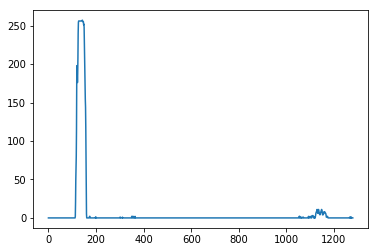

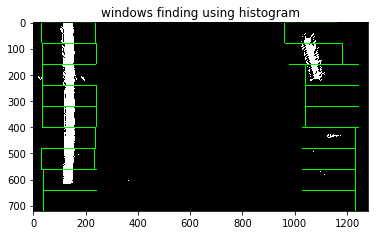

In [249]:
output_img = sliding_window_histogram(warped_img)
image_display(output_img,'windows finding using histogram')

In [242]:
def window_mask(img,center,window_width, window_height, iteration):
    y_low = int(img.shape[0]-(iteration+1)*window_height)
    y_high = int(img.shape[0]-iteration*window_height)
    x_low = max(0,int(center-window_width/2))
    x_high = min(int(center+window_width/2),img.shape[1])
    output = np.zeros_like(img)
    output[y_low:y_high,x_low:x_high] = 1
    return output

def sliding_window_convolve(img, window_height = 50, window_width=100):
    window_centroids = [] # find center of each window (left,right)
    window = np.ones(window_width) # will be used in convolve
    sliding = 100
    left_sum = np.sum(img[3*int(img.shape[0]/4):,0:int(img.shape[1]/2)], axis=0)
    right_sum = np.sum(img[3*int(img.shape[0]/4):,int(img.shape[1]/2):], axis=0)
    
    left_center = np.argmax(np.convolve(window,left_sum))-window_width/2
    right_center = np.argmax(np.convolve(window,right_sum))+ img.shape[1]/2 -window_width/2
    window_centroids.append((left_center,right_center))
    
    n_windows = int(img.shape[0]/window_height)
    offset = int(window_width /2)
    for i in range(1, n_windows):
        y_high = img.shape[0] - i*window_height
        y_low = img.shape[0] - (i+1)*window_height
        image_layer = np.sum(img[y_low:y_high,:], axis=0)
        conv_layer = np.convolve(window,image_layer)
        
        left_min_index = int(max(left_center+offset-sliding,0))
        left_max_index = int(min(left_center+offset+sliding,img.shape[1]))
        left_center = np.argmax(conv_layer[left_min_index:left_max_index]) + left_min_index -offset
        
        right_min_index = int(max(right_center+offset-sliding,0))
        right_max_index = int(min(right_center+offset+sliding,img.shape[1]))
        right_center = np.argmax(conv_layer[right_min_index:right_max_index]) + right_min_index-offset
        
        window_centroids.append((left_center, left_center))
    return window_centroids, n_windows

def draw_convolve_windows(img, window_centroids,window_height = 50, window_width=100, n_windows=10):
    if len(window_centroids)>0:
        # Points used to draw all the left and right windows
        left_points = np.zeros_like(img)
        right_points = np.zeros_like(img)
        for i in range(0,n_windows):
            center = window_centroids[i]
            left_mask = window_mask(img,center[0],window_width,window_height,i)
            right_mask = window_mask(img,center[1],window_width,window_height,i)
            # Add graphic points from window mask here to total pixels found 
            left_points[(left_points == 255) | ((left_mask == 1) ) ] = 255
            right_points[(right_points == 255) | ((right_mask == 1) ) ] = 255
        # Draw the results
        template = np.array(right_points+left_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        output_img = np.dstack((img, img, img))*255
        output = cv2.addWeighted(output_img, 0.7,template , 0.3, 0.0) # overlay the orignal road image with window results
    #If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((img,img,img)),np.uint8)
    
    return output

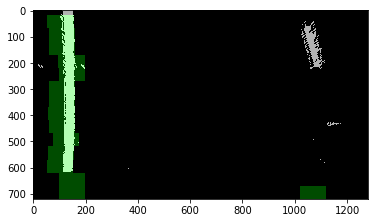

In [244]:
centroids, n_windows = sliding_window_convolve(warped_img)
output = draw_convolve_windows(warped_img, centroids, n_windows=n_windows )
image_display(output, 'windows finding using convolve')